# Trabajo práctico 3 - Organización de datos
## Parte III: Machine Learning (modelo 1 - Random Forest)
### Facultad de ingeniería - Universidad de Buenos Aires


---


Alumna: Agustina Bocaccio \\
Padron: 106393 \\
Email: abocaccio@fi.uba.ar \\

---

#### Segundo cuatrimestre 2021
#### Fecha de entrega: 28 de noviembre de 2021

## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import CountVectorizer

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id='1YGDFxRvxm1wMVaL3E5GpgP2KQqun8OFj'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_identity.csv')

train_identity  = pd.read_csv('train_identity.csv')

In [ ]:
id='1vAH4o97zYZ2RT8Mbgz3Be4AN2xxbA_4W'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('train_transaction.csv')

train_transaction  = pd.read_csv('train_transaction.csv')

In [ ]:
joined = pd.merge(train_transaction, train_identity, how = 'left')
joined

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.50,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.00,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.00,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.00,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.00,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,3577535,0,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590536,3577536,0,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590537,3577537,0,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
590538,3577538,0,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
del train_transaction
del train_identity

## Funciones auxiliares

In [ ]:
def get_column_types(df, type):
  columns = []
  for column in df:
    if(df[column].dtype ==type):
      columns.append(column)
  return columns

In [ ]:
#aplico mean encoding a la columna recibida por parametros y guardo el encoding para esa columna en el diccionario recibido por parametros.

def mean_encoding(df, column, min, mean_encoding_dicts, na_filler):
   df[column].fillna('Unknown', inplace = True)
   dict_amount = df[column].value_counts().to_dict()
   df['amount'] = df[column].map(dict_amount)
   df.loc[df['amount']<min, column]='Other'
   mean_column = df.groupby([column])['isFraud'].mean().to_dict()
   df[column] = df[column].map(mean_column)
   na_filler[column] = mean_column['Unknown']
   mean_encoding_dicts[column] =mean_column
   df.drop(columns=['amount'], inplace=True)

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def plot_roc(_fpr, _tpr, x):

    roc_auc = auc(_fpr, _tpr)

    plt.figure(dpi=100)
    plt.plot(
        _fpr, _tpr, color='darkorange', lw=2, label=f'AUC score: {roc_auc:.2f}'
    )
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

    
def auc_roc_plot(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    plot_roc(fpr, tpr, thresholds)
    print(f"El valor de la metrica AUC-ROC para este modelo es: {roc_auc_score(y_test, y_pred)}")

## Preparacion del dataset

In [ ]:
features = ['isFraud', 'id_03', 'V141', 'V142', 'id_09', 'V147', 'V138', 'V146',
       'id_23', 'card4', 'V325', 'V239', 'V185', 'V238', 'V184', 'V235', 'ProductCD', 
       'V237', 'V181', 'V236', 'V327', 'V101', 'V231', 'V233', 'V301', 'id_34', 'V177', 'V232',
       'V300', 'V183', 'V104', 'V281', 'V330', 'V328', 'V227', 'V106', 'V297',
       'V98', 'V179', 'V217', 'id_31', 'V103', 'V329', 'V299',
       'DeviceType', 'V219', 'V167', 'V326', 'V95', 'V226', 'V40', 'V52', 'V79', 'V322', 'V182', 'V175', 
       'M4', 'V18', 'V324', 'V17', 'V218', 'V178', 'V81', 'V33', 'V220', 'V34', 'V51',
       'V39', 'V16', 'V15', 'V225', 'V74', 'V94', 'V80', 'V93', 'V180', 'V58',
       'V293', 'V43', 'P_emaildomain','R_emaildomain', 'TransactionAmt', 'C1', 'C2', 'C3',
        'C4', 'C5', 'C6', 'C7', 'C8',	'C9','C10',	'C11',	'C12',	'C13',	'C14' ,'id_33', 'TransactionDT',
         'V87', 'DeviceInfo', 'M1', 'M2', 'M3', 'M5', 'D1', 'id_27',	'id_28',	'id_29', 'id_30']

In [ ]:
joined_selected_features = joined.loc[:, features]
joined_selected_features

,isFraud,id_03,V141,V142,id_09,V147,V138,V146,id_23,card4,V325,V239,V185,V238,V184,V235,ProductCD,V237,V181,V236,V327,V101,V231,V233,V301,id_34,V177,V232,V300,V183,V104,V281,V330,V328,V227,V106,V297,V98,V179,V217,...,V15,V225,V74,V94,V80,V93,V180,V58,V293,V43,P_emaildomain,R_emaildomain,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,id_33,TransactionDT,V87,DeviceInfo,M1,M2,M3,M5,D1,id_27,id_28,id_29,id_30
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,discover,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,68.50,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,NaN,86400,1.0,NaN,T,T,T,F,14.0,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,gmail.com,NaN,29.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,86401,1.0,NaN,NaN,NaN,NaN,T,0.0,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,visa,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,outlook.com,NaN,59.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,86469,1.0,NaN,T,T,T,F,0.0,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,yahoo.com,NaN,50.00,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,NaN,86499,1.0,NaN,NaN,NaN,NaN,T,112.0,NaN,NaN,NaN,NaN
4,0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,mastercard,0.0,0.0,0.0,0.0,0.0,0.0,H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,match_status:2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,gmail.com,NaN,50.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2220x1080,86506,NaN,SAMSUNG SM-G892A Build/NRD90M,NaN,NaN,NaN,NaN,0.0,NaN,New,NotFound,Android 7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,visa,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,49.00,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,NaN,15811047,1.0,NaN,T,T,T,T,29.0,NaN,NaN,NaN,NaN
590536,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,gmail.com,NaN,39.50,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,15811049,1.0,NaN,T,F,F,F,0.0,NaN,NaN,NaN,NaN
590537,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,gmail.com,NaN,30.95,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,15811079,1.0,NaN,T,F,F,NaN,0.0,NaN,NaN,NaN,NaN
590538,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,1.0,NaN,NaN,...,0.0,NaN,1.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,aol.com,NaN,117.00,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,NaN,15811088,1.0,NaN,T,T,T,F,22.0,NaN,NaN,NaN,NaN


In [ ]:
train_set = joined_selected_features.head(int(len(joined)*0.8)).copy()
validation_set = joined_selected_features.tail(int(len(joined)*0.2)).copy()

In [ ]:
train_set

,isFraud,id_03,V141,V142,id_09,V147,V138,V146,id_23,card4,V325,V239,V185,V238,V184,V235,ProductCD,V237,V181,V236,V327,V101,V231,V233,V301,id_34,V177,V232,V300,V183,V104,V281,V330,V328,V227,V106,V297,V98,V179,V217,...,V15,V225,V74,V94,V80,V93,V180,V58,V293,V43,P_emaildomain,R_emaildomain,TransactionAmt,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,id_33,TransactionDT,V87,DeviceInfo,M1,M2,M3,M5,D1,id_27,id_28,id_29,id_30
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,discover,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,68.50,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,NaN,86400,1.0,NaN,T,T,T,F,14.0,NaN,NaN,NaN,NaN
1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,gmail.com,NaN,29.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,NaN,86401,1.0,NaN,NaN,NaN,NaN,T,0.0,NaN,NaN,NaN,NaN
2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,visa,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,outlook.com,NaN,59.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,86469,1.0,NaN,T,T,T,F,0.0,NaN,NaN,NaN,NaN
3,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,1.0,0.0,yahoo.com,NaN,50.00,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,NaN,86499,1.0,NaN,NaN,NaN,NaN,T,112.0,NaN,NaN,NaN,NaN
4,0,NaN,0.0,0.0,NaN,0.0,0.0,0.0,NaN,mastercard,0.0,0.0,0.0,0.0,0.0,0.0,H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,match_status:2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,gmail.com,NaN,50.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,2220x1080,86506,NaN,SAMSUNG SM-G892A Build/NRD90M,NaN,NaN,NaN,NaN,0.0,NaN,New,NotFound,Android 7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,visa,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,hotmail.com,NaN,43.95,1.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,NaN,12192667,1.0,NaN,T,T,T,NaN,6.0,NaN,NaN,NaN,NaN
472428,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,visa,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,2.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,gmail.com,NaN,49.00,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,NaN,12192736,1.0,NaN,T,T,T,T,0.0,NaN,NaN,NaN,NaN
472429,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,NaN,visa,0.0,0.0,0.0,0.0,0.0,0.0,H,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,match_status:2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,NaN,0.0,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,gmail.com,gmail.com,40.00,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1440x900,12192742,NaN,MacOS,NaN,NaN,NaN,NaN,0.0,NaN,Found,Found,Mac OS X 10_13_3
472430,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mastercard,NaN,NaN,NaN,NaN,NaN,NaN,W,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,0.0,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,NaN,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,gmail.com,NaN,15.00,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,NaN,12192743,1.0,NaN,T,T,T,T,382.0,NaN,NaN,NaN,NaN


Aplico CountVectorizer a la columna DeviceInfo

In [ ]:
vectorizer = CountVectorizer(lowercase = True, max_features = 30)
train_set['DeviceInfo'].fillna('Unknown', inplace = True)
matrix = vectorizer.fit_transform(train_set['DeviceInfo'])
df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
for column in df:
  train_set[column] = df[column]

del df

Encodeo las columnas:

In [ ]:
categorical_features = get_column_types(train_set, object)
numerical_features = get_column_types(train_set, np.float64)

In [ ]:
seconds_in_day = 24*60*60

train_set['sin_time'] = np.sin(2*np.pi*train_set.TransactionDT/seconds_in_day)
train_set['cos_time'] = np.cos(2*np.pi*train_set.TransactionDT/seconds_in_day)

train_set.drop('TransactionDT', axis=1, inplace=True)

encoding_dicts = {}
one_hot_encoding_columns = []
na_filler = {}

for column in categorical_features:
  if(len(train_set[column].value_counts())>10):
    mean_encoding(train_set, column, 500, encoding_dicts, na_filler)
  else:
    one_hot_encoding_columns.append(column)

train_set = pd.get_dummies(train_set, dummy_na=True, drop_first=True, columns=one_hot_encoding_columns)

In [ ]:
for column in numerical_features: 
  na_value =  train_set[column].sum()/len(train_set[column])
  na_filler[column] = na_value
  train_set[column].fillna(na_value, inplace=True)

In [ ]:
train_set

,isFraud,id_03,V141,V142,id_09,V147,V138,V146,V325,V239,V185,V238,V184,V235,V237,V181,V236,V327,V101,V231,V233,V301,V177,V232,V300,V183,V104,V281,V330,V328,V227,V106,V297,V98,V179,V217,id_31,V103,V329,V299,...,trident,unknown,windows,sin_time,cos_time,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,card4_discover,card4_mastercard,card4_visa,card4_nan,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,DeviceType_mobile,DeviceType_nan,M4_M1,M4_M2,M4_nan,M1_T,M1_nan,M2_T,M2_nan,M3_T,M3_nan,M5_T,M5_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan
0,0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,...,0,1,0,6.432491e-16,1.000000,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1
1,0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,...,0,1,0,7.272205e-05,1.000000,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1
2,0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,...,0,1,0,5.017801e-03,0.999987,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1
3,0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,1.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,24.0,0.030231,0.0,...,0,1,0,7.199421e-03,0.999974,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1
4,0,0.007106,0.00000,0.00000,0.012935,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.070755,0.0,0.000000,0.0,...,0,0,0,7.708461e-03,0.999970,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,...,0,1,0,6.791745e-01,0.733977,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1
472428,0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,2.0,0.084816,0.121914,2.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,2.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,2.0,...,0,1,0,6.828489e-01,0.730560,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1
472429,0,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0

In [ ]:
#me fijo que no haya columnas con valores no numericos
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472432 entries, 0 to 472431
Columns: 162 entries, isFraud to id_29_nan
dtypes: float64(96), int64(31), uint8(35)
memory usage: 477.1 MB


Me aseguro que no hallan quedado valores nulos en el dataset

In [ ]:
a = pd.DataFrame({'Cantidad de nulos': train_set.isnull().sum(), 'Porcentaje de nulos': (train_set.isnull().mean() * 100)})
nulos = a.loc[a['Cantidad de nulos']!= 0, :]
nulos

,Cantidad de nulos,Porcentaje de nulos


## Busqueda de hiperparámetros

In [ ]:
y_train = train_set['isFraud']
train_set.drop(columns=['isFraud'], inplace=True)
X_train = train_set

In [ ]:
X_train

,id_03,V141,V142,id_09,V147,V138,V146,V325,V239,V185,V238,V184,V235,V237,V181,V236,V327,V101,V231,V233,V301,V177,V232,V300,V183,V104,V281,V330,V328,V227,V106,V297,V98,V179,V217,id_31,V103,V329,V299,V219,...,trident,unknown,windows,sin_time,cos_time,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,card4_discover,card4_mastercard,card4_visa,card4_nan,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,DeviceType_mobile,DeviceType_nan,M4_M1,M4_M2,M4_nan,M1_T,M1_nan,M2_T,M2_nan,M3_T,M3_nan,M5_T,M5_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan
0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,0.184558,...,0,1,0,6.432491e-16,1.000000,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1
1,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,0.184558,...,0,1,0,7.272205e-05,1.000000,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1
2,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,0.184558,...,0,1,0,5.017801e-03,0.999987,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,0,0,0,1,0,1,0,1
3,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,1.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,24.0,0.030231,0.0,0.184558,...,0,1,0,7.199421e-03,0.999974,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,1,0,0,1,0,1,0,1
4,0.007106,0.00000,0.00000,0.012935,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.070755,0.0,0.000000,0.0,0.000000,...,0,0,0,7.708461e-03,0.999970,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
472427,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,0.184558,...,0,1,0,6.791745e-01,0.733977,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,0,1,0,1,0,0,1,0,1,0,1,0,1
472428,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,2.0,0.084816,0.121914,2.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,2.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,2.0,0.184558,...,0,1,0,6.828489e-01,0.730560,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1
472429,0.000000,0.00000,0.00000,1.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0

In [ ]:
# para obtener el modelo entrenado guardado
import pickle 

with open('model_backup', 'rb') as file:
  best_random_forest, encoding_dicts, na_filler, one_hot_encoding_columns, X_train, vectorizer= pickle.load(file)

In [ ]:
random_grid = {'bootstrap': [True, False],
               'max_depth': [10, 20, 30, 40, 50, 60, 100, 110, None],
               'max_features': ['auto', 'sqrt'],
               'min_samples_leaf': [1, 2, 4],
               'min_samples_split': [2, 5, 10],
               'n_estimators': [100, 150, 200]}

In [ ]:
from sklearn.ensemble import RandomForestClassifier

random_forest =RandomForestClassifier(random_state=1)
best_random_forest = RandomizedSearchCV(random_forest, random_grid, random_state=1, n_jobs=1, n_iter=4, verbose=100, scoring = 'roc_auc')
best_random_forest.fit(X_train.values, y_train.values)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 1/5; 1/4] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.847 total time= 2.6min
[CV 2/5; 1/4] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 2/5; 1/4] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.857 total time= 2.7min
[CV 3/5; 1/4] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150
[CV 3/5; 1/4] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=150;, score=0.876 total time= 2.7min
[CV 4/5; 1/4] START bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf

RandomizedSearchCV(estimator=RandomForestClassifier(random_state=1), n_iter=4,
                   n_jobs=1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      100, 110, None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 150, 200]},
                   random_state=1, scoring='roc_auc', verbose=100)

In [ ]:
#para guardar modelo
import pickle
with open('model_backup', 'wb') as model_backup_file:
  pickle.dump((best_random_forest, encoding_dicts, na_filler, one_hot_encoding_columns, X_train, vectorizer), model_backup_file)

In [ ]:
roc_auc_score(y_train.values, best_random_forest.predict_proba(X_train.values)[:,1])

0.9992084633789985

In [ ]:
print(classification_report(y_train.values, best_random_forest.predict(X_train.values))) 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    455833
           1       1.00      0.59      0.74     16599

    accuracy                           0.99    472432
   macro avg       0.99      0.79      0.87    472432
weighted avg       0.99      0.99      0.98    472432



## Prediccion para validation

In [ ]:
validation_set['DeviceInfo'].fillna('Unknown', inplace = True)
matrix = vectorizer.transform(validation_set['DeviceInfo'])
df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
validation_set.reset_index(inplace = True, drop = True)

In [ ]:
for column in df:
  validation_set[column] = df[column]

del df

In [ ]:
seconds_in_day = 24*60*60

validation_set['sin_time'] = np.sin(2*np.pi*validation_set.TransactionDT/seconds_in_day)
validation_set['cos_time'] = np.cos(2*np.pi*validation_set.TransactionDT/seconds_in_day)

validation_set.drop('TransactionDT', axis=1, inplace=True)

for column in encoding_dicts:
  validation_set[column] = validation_set[column].map(encoding_dicts[column])

validation_set = pd.get_dummies(validation_set, dummy_na=True, drop_first=True, columns=one_hot_encoding_columns)

for column in na_filler: 
  validation_set[column].fillna(na_filler[column], inplace=True)

In [ ]:
y_validation = validation_set['isFraud']
validation_set.drop(columns=['isFraud'], inplace= True)
X_validation = validation_set

In [ ]:
# Puede haber columnas en train_set que no esten en validation set debido al get_dummies, para estos casos genero las columnas necesarias y las pongo en 0
difference = list(set(X_train.columns).difference(set(X_validation.columns)))

for column in difference:
  X_validation[column] = 0

X_validation.reindex(columns=X_train.columns)

,id_03,V141,V142,id_09,V147,V138,V146,V325,V239,V185,V238,V184,V235,V237,V181,V236,V327,V101,V231,V233,V301,V177,V232,V300,V183,V104,V281,V330,V328,V227,V106,V297,V98,V179,V217,id_31,V103,V329,V299,V219,...,trident,unknown,windows,sin_time,cos_time,id_23_IP_PROXY:HIDDEN,id_23_IP_PROXY:TRANSPARENT,id_23_nan,card4_discover,card4_mastercard,card4_visa,card4_nan,ProductCD_H,ProductCD_R,ProductCD_S,ProductCD_W,ProductCD_nan,id_34_match_status:0,id_34_match_status:1,id_34_match_status:2,id_34_nan,DeviceType_mobile,DeviceType_nan,M4_M1,M4_M2,M4_nan,M1_T,M1_nan,M2_T,M2_nan,M3_T,M3_nan,M5_T,M5_nan,id_27_NotFound,id_27_nan,id_28_New,id_28_nan,id_29_NotFound,id_29_nan
0,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.02079,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.023836,0.020919,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.106546,0.0,0.030231,0.0,0.000000,...,0,1,0,0.691513,0.722364,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0
1,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.02079,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.023836,0.020919,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.141343,0.0,0.030231,0.0,0.000000,...,0,0,0,0.692091,0.721811,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,1,0,1,0,1,0,1,1,0,1,0
2,6.000000,0.00547,0.00667,6.000000,0.023045,0.005535,0.021254,0.00671,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.02079,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.023836,0.020919,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.106546,0.0,0.030231,0.0,0.000000,...,0,0,1,0.692196,0.721710,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0
3,6.000000,0.00547,0.00667,6.000000,0.023045,0.005535,0.021254,0.00671,1.00000,1.000000,1.0000,1.000000,1.000000,1.000000,1.00000,1.000000,0.02079,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.023836,0.020919,0.000000,0.0,0.0,0.0,0.000000,1.000000,0.106546,0.0,0.030231,0.0,1.000000,...,0,0,1,0.698832,0.715286,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,1,0,1,0,1,0,0,0,0
4,0.007106,0.00000,0.00000,0.012935,0.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.060345,0.0,0.000000,0.0,0.000000,...,0,0,1,0.707055,0.707158,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118103,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,0.184558,...,0,1,0,-0.011126,0.999938,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,1,0,1,0,1
118104,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.084816,0.121914,0.0,0.051624,0.0,0.0,0.023836,0.020919,0.037315,0.0,0.0,0.0,0.132307,0.143394,0.021362,0.0,0.030231,0.0,0.184558,...,0,1,0,-0.010981,0.999940,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,1
118105,0.007106,0.00547,0.00667,0.012935,0.023045,0.005535,0.021254,0.00671,0.03268,0.033569,0.0305,0.030934,0.032673,0.037898,0.03536,0.046879,0.02079,0.0,0.086597,0.102446,0.0,0.

In [ ]:
roc_auc_score(y_validation.values, best_random_forest.predict_proba(X_validation.values)[:,1])

0.8546296860712277

In [ ]:
print(classification_report(y_validation, best_random_forest.predict(X_validation)))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


              precision    recall  f1-score   support

           0       0.97      1.00      0.99    114044
           1       0.83      0.25      0.39      4064

    accuracy                           0.97    118108
   macro avg       0.90      0.63      0.69    118108
weighted avg       0.97      0.97      0.97    118108



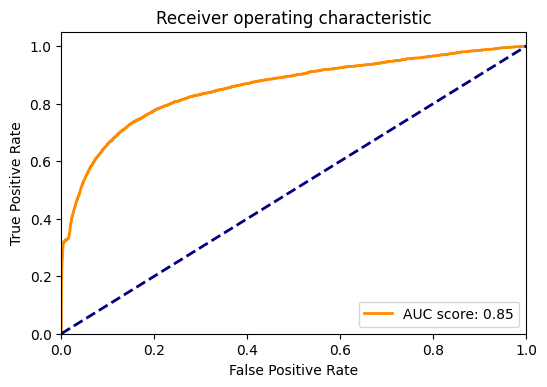

El valor de la metrica AUC-ROC para este modelo es: 0.8546296860712277


In [ ]:
auc_roc_plot(y_validation.values, best_random_forest.predict_proba(X_validation.values)[:,1])

## Prediccion para test 

In [ ]:
id='1w-hO21eHxYs8NgW_NhXZpckfGuQEL22j'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_transaction.csv')

test_transaction = pd.read_csv('test_transaction.csv')

In [ ]:
id='16HGAtDL8NdWSnqE-5WThosY2q0QIoeX-'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('test_identity.csv')

test_identity = pd.read_csv('test_identity.csv')

In [ ]:
test_set = pd.merge(test_transaction, test_identity, how = 'left')

In [ ]:
del test_identity
del test_transaction

In [ ]:
test_set

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id-01,id-02,id-03,id-04,id-05,id-06,id-07,id-08,id-09,id-10,id-11,id-12,id-13,id-14,id-15,id-16,id-17,id-18,id-19,id-20,id-21,id-22,id-23,id-24,id-25,id-26,id-27,id-28,id-29,id-30,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.950,W,10409,111.0,150.0,visa,226.0,debit,170.0,87.0,1.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,3.0,4.0,0.0,0.0,6.0,0.0,5.0,1.0,115.0,6.0,419.0,419.0,27.0,398.0,27.0,NaN,NaN,NaN,NaN,418.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000,W,4272,111.0,150.0,visa,226.0,debit,299.0,87.0,4.0,NaN,aol.com,NaN,3.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,1.0,1.0,12.0,2.0,149.0,149.0,7.0,634.0,7.0,NaN,NaN,NaN,NaN,231.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000,W,4476,574.0,150.0,visa,226.0,debit,472.0,87.0,2635.0,NaN,hotmail.com,NaN,2.0,2.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,0.0,2.0,0.0,22.0,2.0,137.0,137.0,10.0,97.0,10.0,NaN,NaN,NaN,NaN,136.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,284.950,W,10989,360.0,150.0,visa,166.0,debit,205.0,87.0,17.0,NaN,gmail.com,NaN,5.0,2.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,0.0,2.0,0.0,7.0,4.0,42.0,42.0,41.0,242.0,41.0,NaN,NaN,NaN,NaN,242.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.950,W,18018,452.0,150.0,mastercard,117.0,debit,264.0,87.0,6.0,NaN,gmail.com,NaN,6.0,6.0,0.0,0.0,2.0,5.0,0.0,0.0,5.0,0.0,6.0,0.0,14.0,6.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506686,4170235,34214279,94.679,C,13832,375.0,185.0,mastercard,224.0,debit,284.0,60.0,NaN,NaN,gmail.com,gmail.com,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506687,4170236,34214287,12.173,C,3154,408.0,185.0,mastercard,224.0,debit,NaN,NaN,NaN,157.0,hotmail.com,hotmail.com,1.0,3.0,0.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,1.0,1.0,3.0,1.0,16.0,16.0,16.0,16.0,16.0,16.0,16.0,NaN,NaN,0.0,...,-45.0,266704.0,NaN,NaN,-3.0,-10.0,NaN,NaN,NaN,NaN,100.0,NotFound,27.0,NaN,New,NotFound,225.0,15.0,176.0,507.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,NaN,chrome 43.0 for android,NaN,NaN,NaN,F,F,T,F,mobile,ALE-L23 Build/HuaweiALE-L23
506688,4170237,34214326,49.000,W,16661,490.0,150.0,visa,226.0,debit,327.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
506689,4170238,34214337,202.000,W,16621,516.0,150.0,mastercard,224.0,debit,177.0,87.0,NaN,NaN,hotmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,Na

In [ ]:
for columnas in test_set:
  test_set.rename(columns=lambda x: x.replace('id-', 'id_'), inplace = True) 

In [ ]:
features = ['id_03', 'V141', 'V142', 'id_09', 'V147', 'V138', 'V146',
       'id_23', 'card4', 'V325', 'V239', 'V185', 'V238', 'V184', 'V235', 'ProductCD', 
       'V237', 'V181', 'V236', 'V327', 'V101', 'V231', 'V233', 'V301', 'id_34', 'V177', 'V232',
       'V300', 'V183', 'V104', 'V281', 'V330', 'V328', 'V227', 'V106', 'V297',
       'V98', 'V179', 'V217', 'id_31', 'V103', 'V329', 'V299',
       'DeviceType', 'V219', 'V167', 'V326', 'V95', 'V226', 'V40', 'V52', 'V79', 'V322', 'V182', 'V175', 
       'M4', 'V18', 'V324', 'V17', 'V218', 'V178', 'V81', 'V33', 'V220', 'V34', 'V51',
       'V39', 'V16', 'V15', 'V225', 'V74', 'V94', 'V80', 'V93', 'V180', 'V58',
       'V293', 'V43', 'P_emaildomain','R_emaildomain', 'TransactionAmt', 'C1', 'C2', 'C3',
        'C4', 'C5', 'C6', 'C7', 'C8',	'C9','C10',	'C11',	'C12',	'C13',	'C14' ,'id_33', 'TransactionDT',
         'V87', 'DeviceInfo', 'M1', 'M2', 'M3', 'M5', 'D1', 'id_27',	'id_28',	'id_29', 'id_30']

In [ ]:
test_set_selected_features = test_set.loc[:, features]

In [ ]:
test_set['DeviceInfo'].fillna('Unknown', inplace = True)
matrix = vectorizer.transform(test_set['DeviceInfo'])
df = pd.DataFrame(matrix.toarray(), columns=vectorizer.get_feature_names_out())
test_set.reset_index(inplace = True, drop = True)

In [ ]:
for column in df:
  test_set[column] = df[column]

del df

In [ ]:
difference_1 = list(set(encoding_dicts.keys()).difference(set(test_set.columns))) + list(set(one_hot_encoding_columns).difference(set(test_set.columns))) + list(set(na_filler.keys()).difference(set(test_set.columns)))
for column in difference_1:
  test_set[column] = 0

In [ ]:
transaction_id = test_set.loc[:, ['TransactionID']]
test_set.drop(columns= 'TransactionID', inplace=True)

In [ ]:
seconds_in_day = 24*60*60

test_set['sin_time'] = np.sin(2*np.pi*test_set.TransactionDT/seconds_in_day)
test_set['cos_time'] = np.cos(2*np.pi*test_set.TransactionDT/seconds_in_day)

test_set.drop('TransactionDT', axis=1, inplace=True)

for column in encoding_dicts:
  test_set[column] = test_set[column].map(encoding_dicts[column])

test_set = pd.get_dummies(test_set, dummy_na=True, drop_first=True, columns=one_hot_encoding_columns)

In [ ]:
for column in na_filler: 
  test_set[column].fillna(na_filler[column], inplace=True)

In [ ]:
# Puede haber columnas en train_set que no esten en validation set debido al get_dummies, para estos casos genero las columnas necesarias y las pongo en 0
difference_2 = list(set(X_train.columns).difference(set(test_set.columns)))

for column in difference_2:
  test_set[column] = 0

In [ ]:
test_set =  test_set.reindex(columns=X_train.columns)

## Matriz de confusion

Text(115.7222222222223, 0.5, 'Real')

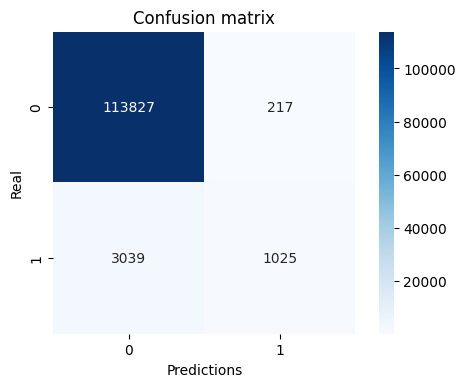

In [ ]:
from sklearn.metrics import confusion_matrix

fig, ax = plt.subplots(dpi=100)
sns.heatmap(confusion_matrix(y_validation, best_random_forest.predict(validation_set.values)),annot=True, ax=ax,fmt="d",square = True,cmap=plt.cm.Blues)
ax.set_title("Confusion matrix")
ax.set_xlabel("Predictions")
ax.set_ylabel("Real")

## Score para la competencia

In [ ]:
predictions_fraud = pd.DataFrame()
predictions_fraud['isFraud'] = best_random_forest.predict_proba(test_set.values)[:,1]
predictions_fraud['TransactionID']= transaction_id.values
predictions_fraud.to_csv('predictions_fraud_random_forest.csv', index=False)

Score obtenido con el random forest: 0.895232

<img src= "https://drive.google.com/uc?id=1nOIm9Nrx79MYHikSqJxtjqsZ9bLQyq8e" width="100%">